# Clustering of Restaurants based on the Fire-stations in Toronto
1. Load the dataframes for Restaurants, Neighborhoods and Fire-stations previously created.
2. Perform K-mean clustering algorithm on the Fire-stations locations, find the best value for Number of Clusters.
3. Fit the K-mean Model on the Restaurant Locations.
4. Visualize the maps and present the results.

Please use this link to open the Jupyter notebook to see the maps: 

https://nbviewer.jupyter.org/

Import neccessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
%matplotlib inline

**Reading the dataframe for neighborhoods and boroughs**

In [2]:
Neighborhood_data=pd.read_csv('Neighborhoods_Toronto.csv')

In [3]:
Neighborhood_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [4]:
print('Number of in Neighborhoods based on postal code',Neighborhood_data.shape[0])

Number of in Neighborhoods based on postal code 103


**Loading the dataframe for the Restaurants**

In [5]:
Restaurant_data=pd.read_csv('Toronto_Restaurants.csv')

In [6]:
Restaurant_data.head()

,Neighborhood,Neighborhood_lat,Neighborhood_long,Restaurant,Restaurant_lat,Restaurant_long
0,"Malvern, Rouge",43.806686,-79.194353,Ted's Restaurant,43.784468,-79.169200
1,"Malvern, Rouge",43.806686,-79.194353,Perfect Chinese Restaurant 雅瓊海鮮酒家,43.787774,-79.270294
2,"Malvern, Rouge",43.806686,-79.194353,Alton Restaurant 益街坊,43.825582,-79.276038
3,"Malvern, Rouge",43.806686,-79.194353,東海漁村 Tasty BBQ Seafood Restaurant (Tasty BBQ S...,43.794425,-79.353300
4,"Malvern, Rouge",43.806686,-79.194353,Federick Restaurant,43.851124,-79.253210


In [7]:
print('Number of Restaurants',Restaurant_data.shape[0])

Number of Restaurants 3090


Let's join the two dataframes on Neighborhood column. This will connect the Restaurants with the Boroughs they are located in as well. 

In [8]:
Combined_data=Restaurant_data.merge(Neighborhood_data,how='left',on='Neighborhood')

In [9]:
Combined_data.drop(columns=['Latitude','Longitude'],inplace=True)

In [10]:
Combined_data.head(5)

,Neighborhood,Neighborhood_lat,Neighborhood_long,Restaurant,Restaurant_lat,Restaurant_long,PostalCode,Borough
0,"Malvern, Rouge",43.806686,-79.194353,Ted's Restaurant,43.784468,-79.169200,M1B,Scarborough
1,"Malvern, Rouge",43.806686,-79.194353,Perfect Chinese Restaurant 雅瓊海鮮酒家,43.787774,-79.270294,M1B,Scarborough
2,"Malvern, Rouge",43.806686,-79.194353,Alton Restaurant 益街坊,43.825582,-79.276038,M1B,Scarborough
3,"Malvern, Rouge",43.806686,-79.194353,東海漁村 Tasty BBQ Seafood Restaurant (Tasty BBQ S...,43.794425,-79.353300,M1B,Scarborough
4,"Malvern, Rouge",43.806686,-79.194353,Federick Restaurant,43.851124,-79.253210,M1B,Scarborough


In [11]:
print('Number of rows',Combined_data.shape[0])

Number of rows 3090


**Loading the dataframe for Fire stations data**

In [12]:
Firestation_data=pd.read_csv('Firestations_Toronto.csv')

In [13]:
Firestation_data.head()

,Fire_station_#,x_6degree_UTM_coordinate,y_6degree_UTM_coordinate,longitude,latitude
0,111,629254.562,4849606.500,-79.393539,43.788230
1,112,625241.895,4847922.113,-79.443786,43.773759
2,113,632675.000,4849871.000,-79.350979,43.790005
3,114,627526.500,4847651.500,-79.415473,43.770934
4,115,633496.245,4847881.079,-79.341271,43.771948


In [14]:
print('Number of Fire stations',Firestation_data.shape[0])

Number of Fire stations 83


## Visualizing the Geo-locations of Restaurants and Firestations

Text(0.5, 1.0, 'Geo-Location of Restaurants and Firestations')

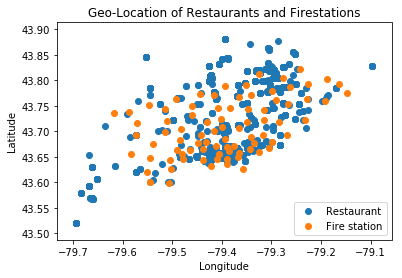

In [15]:
plt.scatter(Combined_data.Restaurant_long,Combined_data.Restaurant_lat,label='Restaurant')
plt.scatter(Firestation_data.longitude,Firestation_data.latitude,label='Fire station')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geo-Location of Restaurants and Firestations')

As it can be seen a bunch of restaurants are outside the area where fire-stations are present. We remove those from our analysis because they would unneccessarily biase the clustering.

In [16]:
Max_long=Firestation_data.longitude.max()
Max_lat=Firestation_data.latitude.max()
Min_long=Firestation_data.longitude.min()
Min_lat=Firestation_data.latitude.min()

Finding the min and max geo-coordinates for fire-stations and restricting the analysis to those restaurants only.

In [17]:
Combined_data_clipped=Combined_data[(Combined_data.Restaurant_long<Max_long)&
                                    (Combined_data.Restaurant_long>Min_long)&
                                     (Combined_data.Restaurant_lat<Max_lat)&
                                    (Combined_data.Restaurant_lat>Min_lat)]

Text(0.5, 1.0, 'Geo-Location of Restaurants and Firestations (Boundary clipped)')

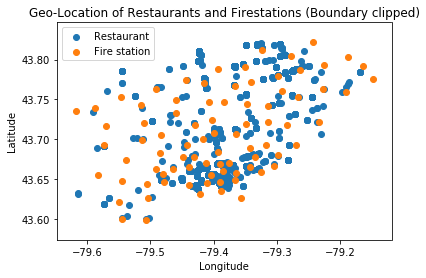

In [18]:
plt.scatter(Combined_data_clipped.Restaurant_long,Combined_data_clipped.Restaurant_lat,label='Restaurant')
plt.scatter(Firestation_data.longitude,Firestation_data.latitude,label='Fire station')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geo-Location of Restaurants and Firestations (Boundary clipped)')

## K-Mean Clustering

We want to distribute the fire-stations into distinct clusters based on there geo-locations. We need to find the optimal number of clusters so that the fire-stations are evenly distributed in the clusters. For that we will try a few 'number of clusters' parameter values. For each value we will estimate the standard deviation of  the number of fire-stations in the clusters. Finally, we choose the model with lowest standard deviation. 

In [19]:
from sklearn.cluster import KMeans

In [20]:
k_cluster_list=[5,6,7,8,9,10]

In [21]:
cluster_diff=np.zeros((len(k_cluster_list),1))
for i in range(len(k_cluster_list)):
    # set number of clusters
    kclusters = k_cluster_list[i]
    firestation_geo = Firestation_data[['longitude','latitude']]
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=1)
    firestation_clusters=kmeans.fit(firestation_geo)
    cluster_diff[i]=pd.Series(firestation_clusters.labels_).value_counts().std()

Text(0.5, 1.0, 'Finding best K-Mean clustering Model')

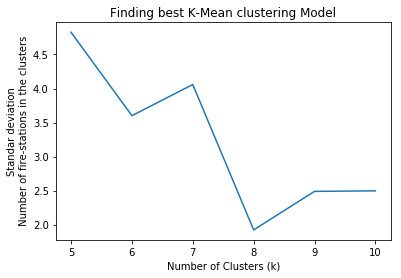

In [22]:
plt.plot(k_cluster_list,cluster_diff)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Standar deviation\n Number of fire-stations in the clusters')
plt.title('Finding best K-Mean clustering Model')

**Lowest standard deviation is seen for k=8, thus we choose this value for the K-Mean clustering model**

Next we train the model on the fire-station so that the fire-stations are divided into clusters based on their geo-location.

In [23]:
# set number of clusters
kclusters = 8
firestation_geo = Firestation_data[['longitude','latitude']]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1)
firestation_clusters=kmeans.fit(firestation_geo)
firestation_clusters.labels_

array([2, 2, 7, 2, 7, 2, 2, 2, 7, 1, 2, 2, 5, 2, 2, 4, 4, 2, 2, 4, 3, 3,
       3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 7, 7, 3, 1, 7, 7, 7, 7, 7, 6, 6, 6,
       6, 6, 1, 1, 1, 1, 6, 1, 6, 6, 6, 6, 6, 5, 5, 5, 6, 5, 6, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0])

The count of fire-stations in each cluster is given below

In [24]:
Firestation_clusters_table=pd.DataFrame({'Cluster label':pd.Series(firestation_clusters.labels_).value_counts().keys(),
            'Number of fire-stations':list(pd.Series(firestation_clusters.labels_).value_counts().values)})
Firestation_clusters_table

,Cluster label,Number of fire-stations
0,6,13
1,2,12
2,1,12
3,5,11
4,7,10
5,4,9
6,3,8
7,0,8


Next we fit the restaurants geo-location data on the fire-station K Mean cluster Model so that the restaurants are distributed according to the clusters of fire-stations. 

In [25]:
restaurant_geo=Combined_data_clipped[['Restaurant_long','Restaurant_lat']]
restaurant_clusters=firestation_clusters.predict(restaurant_geo)

# check cluster labels generated for each row in the dataframe
restaurant_clusters

array([3, 7, 7, ..., 4, 6, 6])

**We look at the number of restaurants belonging to each cluster**

In [26]:
Restaurant_clusters_table=pd.DataFrame({'Cluster label':pd.Series(restaurant_clusters).value_counts().keys(),
                                 'Number of restaurants':list(pd.Series(restaurant_clusters).value_counts().values)})
Restaurant_clusters_table

,Cluster label,Number of restaurants
0,6,1768
1,7,555
2,2,202
3,1,167
4,5,76
5,4,61
6,3,39
7,0,17


**One thing that clearly stands out is that the cluster number 6 has a lot of restaurants under it's range.** Let's combine both clusters data and see how much is a per fire-station responsibility in each cluster.

In [59]:
Combined_cluster_table=Firestation_clusters_table.merge(Restaurant_clusters_table,on='Cluster label')
Combined_cluster_table

,Cluster label,Number of fire-stations,Number of restaurants
0,6,13,1768
1,2,12,202
2,1,12,167
3,5,11,76
4,7,10,555
5,4,9,61
6,3,8,39
7,0,8,17


In [67]:
Combined_cluster_table['Restaurants per Fire-station']=Combined_cluster_table['Number of restaurants']/Combined_cluster_table['Number of fire-stations']
Combined_cluster_table.sort_values('Cluster label', axis=0, ascending=True, inplace=True)
Combined_cluster_table.set_index('Cluster label',inplace=True)
Combined_cluster_table

,Number of fire-stations,Number of restaurants,Restaurants per Fire-station
Cluster label,,,
0,8,17,2.125000
1,12,167,13.916667
2,12,202,16.833333
3,8,39,4.875000
4,9,61,6.777778
5,11,76,6.909091
6,13,1768,136.000000
7,10,555,55.500000


## Visualization of the results
We show the number of fire-stations, number of restaurants and restaurants per fire-station for each cluster label in following barplots. 

Text(0.5, 0.98, 'Distribution among clusters')

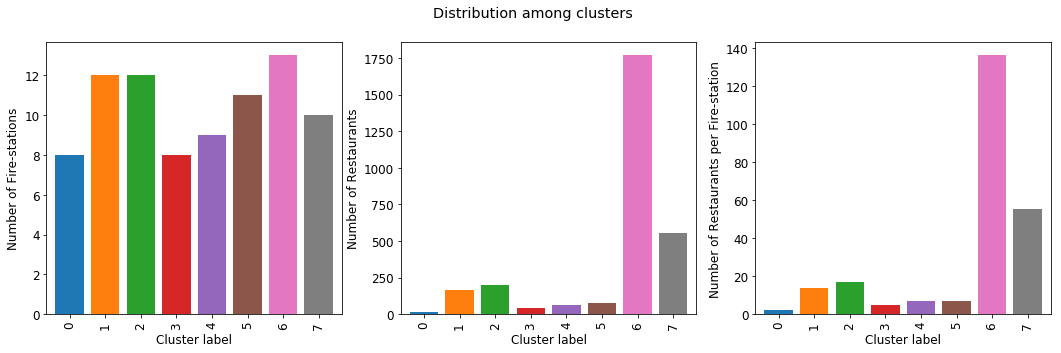

In [84]:
fig, ax=plt.subplots(ncols=3,figsize=(18,5))
Combined_cluster_table['Number of fire-stations'].plot(kind='bar', width=0.8,ax=ax[0])
Combined_cluster_table['Number of restaurants'].plot(kind='bar', width=0.8,ax=ax[1])
Combined_cluster_table['Restaurants per Fire-station'].plot(kind='bar', width=0.8,ax=ax[2])
ax[0].set_ylabel('Number of Fire-stations')
ax[1].set_ylabel('Number of Restaurants')
ax[2].set_ylabel('Number of Restaurants per Fire-station')
fig.suptitle('Distribution among clusters')

**From our analysis we can clearly see that Fire-stations in cluster 6 and 7 have a much larger number of restaurants under them.**

## Next we get the cluster labels into the dataframe of fire-stations and restaurants

In [29]:
Firestation_data.insert(0, 'Cluster Labels', firestation_clusters.labels_)
Combined_data_clipped.insert(0, 'Cluster Labels', restaurant_clusters)

In [30]:
Firestation_data.head()

,Cluster Labels,Fire_station_#,x_6degree_UTM_coordinate,y_6degree_UTM_coordinate,longitude,latitude
0,2,111,629254.562,4849606.500,-79.393539,43.788230
1,2,112,625241.895,4847922.113,-79.443786,43.773759
2,7,113,632675.000,4849871.000,-79.350979,43.790005
3,2,114,627526.500,4847651.500,-79.415473,43.770934
4,7,115,633496.245,4847881.079,-79.341271,43.771948


In [31]:
Combined_data_clipped.head()

,Cluster Labels,Neighborhood,Neighborhood_lat,Neighborhood_long,Restaurant,Restaurant_lat,Restaurant_long,PostalCode,Borough
0,3,"Malvern, Rouge",43.806686,-79.194353,Ted's Restaurant,43.784468,-79.169200,M1B,Scarborough
1,7,"Malvern, Rouge",43.806686,-79.194353,Perfect Chinese Restaurant 雅瓊海鮮酒家,43.787774,-79.270294,M1B,Scarborough
3,7,"Malvern, Rouge",43.806686,-79.194353,東海漁村 Tasty BBQ Seafood Restaurant (Tasty BBQ S...,43.794425,-79.353300,M1B,Scarborough
5,7,"Malvern, Rouge",43.806686,-79.194353,Inware Restaurant Equipment and Supplies 宏鑫餐具,43.804130,-79.296060,M1B,Scarborough
8,7,"Malvern, Rouge",43.806686,-79.194353,Fortune House Restaurant 富記,43.790025,-79.302509,M1B,Scarborough


Finally, let's visualize the clusters and see which locations have the clusters with the most restaurant per fire-stations. So, that the city of Toronto might use this information in city planning.

In [32]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

**First, we show the clusters of fire-stations on the map of Toronto.**

In [102]:
toronto_lat=43.7
toronto_long=-79.3832
# create map of toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to map
for lat, lng, fire_station, cluster in zip(Firestation_data['latitude'], Firestation_data['longitude'],
                                           Firestation_data['Fire_station_#'],Firestation_data['Cluster Labels']):
    label = 'Fire Station # {}, Cluster # {}'.format(fire_station,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color=rainbow[cluster],
      fill=True,
      fill_color=rainbow[cluster],
      fill_opacity=1,
      parse_html=False).add_to(map_toronto)  
    
map_toronto

**The Boroughs and number of restaurants in those boroughs in the critical clusters with highest Restaurant to fire-stations ratio**

Starting with Cluster label 6 which has 136 restaurants per fire-station.

In [34]:
Critical_cluster1=Combined_data_clipped[Combined_data_clipped['Cluster Labels']==6]

In [35]:
Critical_cluster1.Borough.value_counts()

Downtown Toronto    533
North York          256
Etobicoke           233
Central Toronto     210
West Toronto        146
York                116
East Toronto         92
East York            72
Scarborough          66
Queen's Park         30
Mississauga          14
Name: Borough, dtype: int64

Most of these restaurants are in Downtown Toronto as expected in any big metropolis. But along with that in Bouroughs like North York, Etobicoke and Central Toronto.

**Next Cluster Label 7 which has about 55 restaurants per fire-stations.**

In [36]:
Critical_cluster2=Combined_data_clipped[Combined_data_clipped['Cluster Labels']==7]

In [37]:
Critical_cluster2.Borough.value_counts()

Scarborough        300
North York         192
East York           22
Central Toronto     17
Etobicoke           10
York                 7
East Toronto         7
Name: Borough, dtype: int64

In this cluster the Borough of Scarborough and North York has the highest Number of restaurants.

## Finally, let's visualize the clusters of fire-stations and restaurants together. 
Since the number of data-points for restaurants is very high so the folium maps was not able to visualize them, so we resorted to **scatter plot of geo-coordinates**, that also serves the purpose.

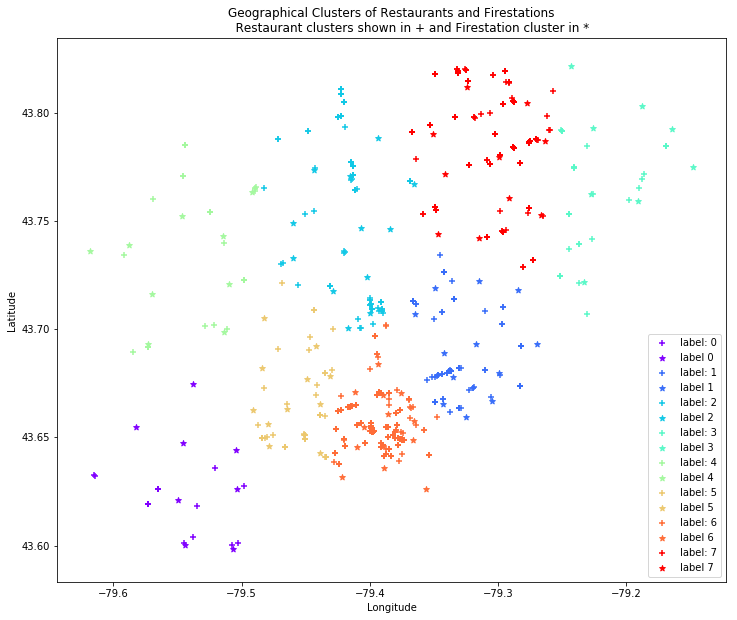

In [38]:
plt.figure(figsize=(12,10))

colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for k in range(kclusters):
    imask=Combined_data_clipped['Cluster Labels']==k
    imask1=Firestation_data['Cluster Labels']==k
    x1=Firestation_data.longitude[imask1]
    y1=Firestation_data.latitude[imask1]
    x=Combined_data_clipped.Restaurant_long[imask]
    y=Combined_data_clipped.Restaurant_lat[imask]
    plt.scatter(x,y,color=rainbow[k],marker='+',label='label: '+str(k))
    plt.scatter(x1,y1,color=rainbow[k],marker='*',label='label '+str(k))
plt.legend(loc=4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Clusters of Restaurants and Firestations\n\
           Restaurant clusters shown in + and Firestation cluster in *')
plt.rc('font',size=12)

# Conclusion
From our analysis of clustering the fire-stations and restaurants we found one aspect of city planning that the city of Toronto keep in mind to prepare for fire accidents that might occur in restaurants. The restaurants handle fire in day-to-day business, so the fire-stations that are closest to them should be in proportion to restaurants in the area. We identified clusters where the ratio of restaurants to fire-stations was highly skewed. So, the city of Toronto needs to pay attention to this fact, either by increasing fire-stations in those areas or upscaling the ones already there. The most critical Boroughs under which these clusters lies are Downtown Toronto , North York and Scarborough 